In [ ]:
"""
Parts of this notebook are based on this repository: https://github.com/hollance/reliability-diagrams which
is licensed under the MIT License. Functionality in this notebook is modified from the original repository.
"""
import os
import numpy as np
import matplotlib.pyplot as plt


def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    print(bins)
    bins[-1] = 0.98
    print(bins)
    #addon = np.ndarray([1.0])
    #bins = np.hstack([bins,addon])
    bins = np.append(bins, [1])
    print(bins)
    num_bins += 1
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

In [213]:
def load_data(method='odin', temper=1000):
    PATH = '/Users/christoph/Downloads/tempering'
    if method == 'baseline': 
        targets = os.path.join(PATH, f'mcp_targets.txt')
        predicted = os.path.join(PATH, f'mcp_pred.txt')
        confidence = os.path.join(PATH, f'mcp_confidence.txt')
    else:
        targets = os.path.join(PATH, f'{method.lower()}_{temper}_targets.txt')
        predicted = os.path.join(PATH, f'{method.lower()}_{temper}_pred.txt')
        confidence = os.path.join(PATH, f'{method.lower()}_{temper}_confidence.txt')

    # correct_list = np.loadtxt(correct, delimiter='\n', converters = {0: lambda s: int(s == 'True')})
    targets_list = np.loadtxt(targets, delimiter='\n')
    confidence_list = np.loadtxt(confidence, delimiter='\n')
    predicted_list = np.loadtxt(predicted, delimiter='\n')

    return targets_list, predicted_list, confidence_list

In [ ]:
# load data for plots
data = {}
bins = 10
for t in [1000, 10, 8, 5, 4, 2, 1]:
    true_labels, pred_labels, confidences = load_data(temper=t)
    data[str(t)] = compute_calibration(true_labels, pred_labels, confidences, num_bins=bins)
    print(f'ECE for temper {t}: {data[str(t)]["expected_calibration_error"]}\nBin Count: {data[str(t)]["counts"]}')

true_labels, pred_labels, confidences = load_data(method='baseline')
data["baseline"] = compute_calibration(true_labels, pred_labels, confidences, num_bins=bins)
print(f'ECE for baseline: {data["baseline"]["expected_calibration_error"]}')

In [ ]:
for t in [1000, 10, 8, 5, 4, 2, 1, "baseline"]:
    new = []
    for k, point in enumerate(data[str(t)]["bins"][:-1]):
        new.append((point + data[str(t)]["bins"][k+1])/2)
    data[str(t)]["bins"] = new
    data[str(t)]["accuracies"] = [float('nan') if x == 0 else x for x in data[str(t)]["accuracies"]]
    # data[str(t)]["accuracies"] = [float('nan') if data[str(t)]["bins"][i] < 10 else x for i, x in enumerate(data[str(t)]["accuracies"])]

data["1"]["accuracies"][7] = float('nan')
data["1"]["accuracies"][8] = float('nan')
data["5"]["accuracies"][5] = float('nan')
print(len(data["1000"]["bins"]), len(data["1000"]["accuracies"]))

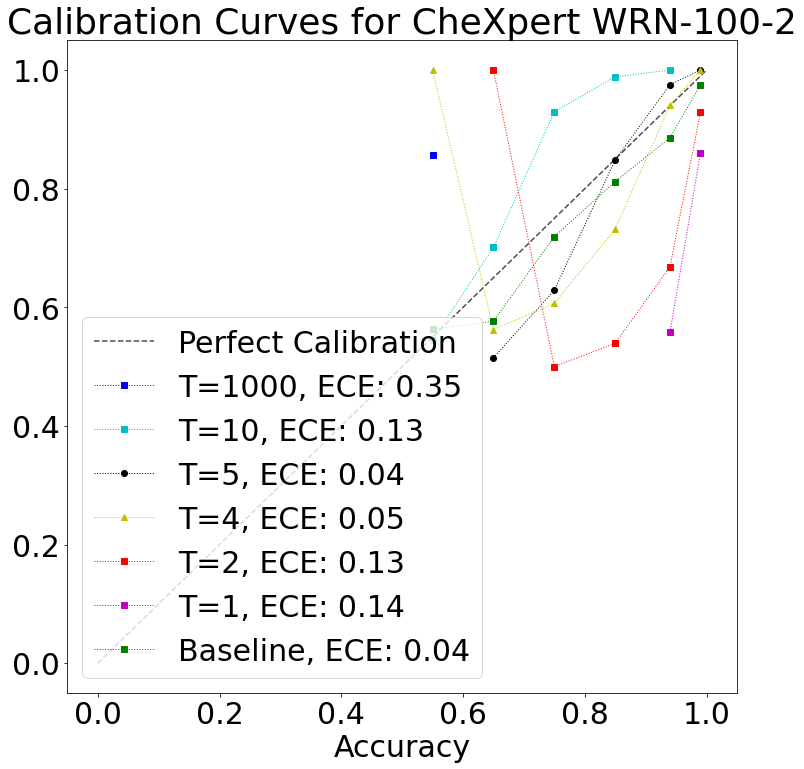

In [216]:
# plot the different calibrations for each temper 
aa = True
linestyle = ':'
linewidth = 1.0

f, ax = plt.subplots(figsize=(12,12))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Perfect Calibration")
ax.plot(data["1000"]["bins"],data["1000"]["accuracies"],f'{linestyle}bs', aa=aa, label=f'T=1000, ECE: {data["1000"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["10"]["bins"],data["10"]["accuracies"],f'{linestyle}cs', aa=aa, label=f'T=10, ECE: {data["10"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["5"]["bins"],data["5"]["accuracies"],f'{linestyle}ko', aa=aa, label=f'T=5, ECE: {data["5"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["4"]["bins"],data["4"]["accuracies"],f'{linestyle}y^', aa=aa, label=f'T=4, ECE: {data["4"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["2"]["bins"],data["2"]["accuracies"],f'{linestyle}rs', aa=aa, label=f'T=2, ECE: {data["2"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["1"]["bins"],data["1"]["accuracies"],f'{linestyle}ms', aa=aa, label=f'T=1, ECE: {data["1"]["expected_calibration_error"]:.2f}', lw=linewidth)
ax.plot(data["baseline"]["bins"],data["baseline"]["accuracies"],f'{linestyle}gs', aa=aa, label=f'Baseline, ECE: {data["baseline"]["expected_calibration_error"]:.2f}', lw=linewidth)

ax.set_title('Calibration Curves for CheXpert WRN-100-2')
ax.set_xlabel('Confidence Score')
ax.set_xlabel('Accuracy')
ax.legend()

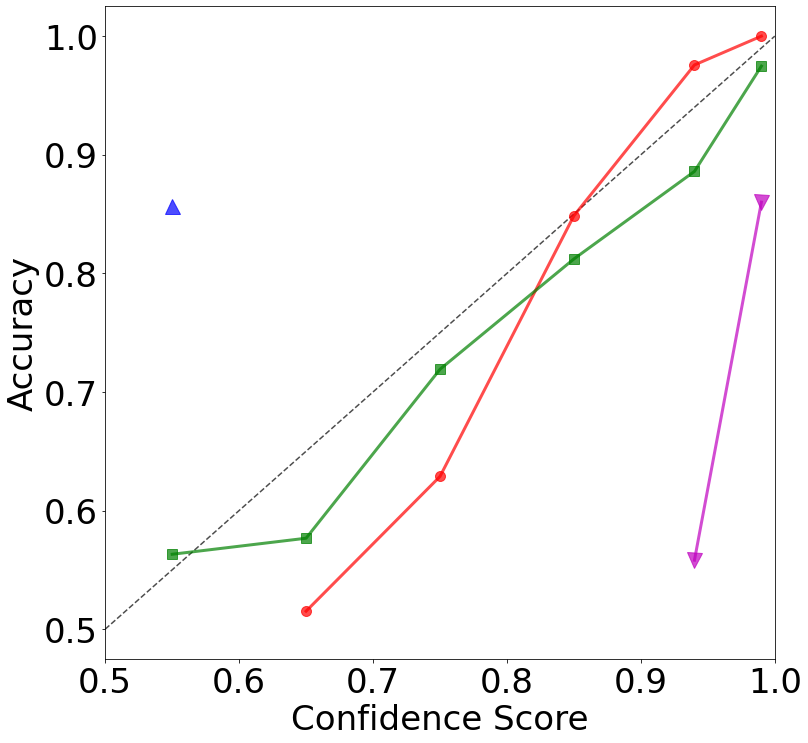

In [219]:
# plot the different calibrations for each temper (only the best!)
aa = True
linestyle = '-'
linewidth = 3.0
al = 0.7
markersize = 10.0 
offset = 0.5

f, ax = plt.subplots(figsize=(12,12))
ident = [0.5,1.0]
ax.plot(ident, ident, ls="--", c=".3", label="Perfect Calibration")
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Perfect Calibration")
ax.plot(data["1000"]["bins"],data["1000"]["accuracies"],f'{linestyle}b^', ms=markersize*1.5, aa=aa, label=f'T=1000, ECE: {data["1000"]["expected_calibration_error"]:.2f}', lw=linewidth, alpha=al)
ax.plot(data["5"]["bins"],data["5"]["accuracies"],f'{linestyle}ro', ms=markersize, aa=aa, label=f'T=5, ECE: {data["5"]["expected_calibration_error"]:.2f}', lw=linewidth, alpha=al)
ax.plot(data["1"]["bins"],data["1"]["accuracies"],f'{linestyle}mv', ms=markersize*1.5, aa=aa, label=f'T=1, ECE: {data["1"]["expected_calibration_error"]:.2f}', lw=linewidth, alpha=al)
ax.plot(data["baseline"]["bins"],data["baseline"]["accuracies"],f'{linestyle}gs', ms=markersize, aa=aa, label=f'Baseline, ECE: {data["baseline"]["expected_calibration_error"]:.2f}', lw=linewidth, alpha=al)

# plotting some lines to clear up the plot
#ax.axhline(y=data["1000"]["accuracies"][5], xmin=0.53-offset, xmax=0.57-offset, color='b')
#ax.axhline(y=data["1000"]["accuracies"][5], xmin=0.93-offset, xmax=0.97-offset, color='m')
# ax.set_title('Calibration Curves for CheXpert WRN-100-2')
ax.set_xlabel('Confidence Score', fontsize=34)
ax.set_ylabel('Accuracy', fontsize=34)
plt.rcParams.update({'font.size': 34})
#ax.set_xticks([0.5, 1.0])
#ax.set_yticks([0.5, 1.0])
ax.margins(x=0)
# ax.legend(prop={'size': 12})
plt.savefig('calibration_raw.pdf')